Garbage Classification Project

In [39]:
#Importing Requied Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.applications import EfficientNetV2B2

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

import os

import gradio as gr
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from PIL import Image

In [6]:
#Importing All the images

#r-> raw string since in path we have backslashes (\) but generally we use them for escape sequencies like \n to avoid this we prefixed with r
dataset_dir = r"C:\Users\Amaravadi Sanjay\Desktop\AICTE-Internship\Garbage Classifier\dataset"
#Updated Version
#dataset_path = os.path.join("C:", "Users", "Amaravadi sanjay", "Desktop", "AICTE-Internship", "Garbage Clssifier", "dataset")

image_size = (160, 160) #Resizeing mage based on model requirement (width,height)
batch_size = 32         #group images processing at a time (16,32,64)
seed = 42               #maintain reproducibility

1. Understanding the Dataset

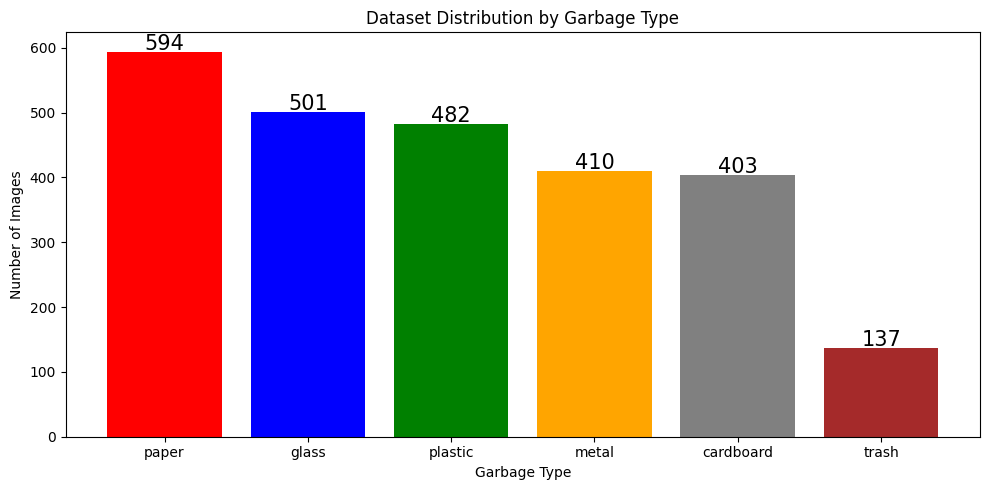

In [7]:
#Ploting a bar graph showing the data 

class_counts = {}   #Dictionary {class name : count} key:folder name, value = images count

for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_dir):
        num_images = len([file for file in os.listdir(class_dir) if file.lower().endswith(('.jpg', '.png', '.jpeg'))])
        #adding all the images to a list and finding the length of it to get the images count
        class_counts[class_name] = num_images

#sorting the count in descending order
sorted_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))
''' 
class_counts.items() reutrn the list of tuples as [(key,value), (k,v), (k,v)]
sorted() used to sort the values in ascending oreder
reverse = True : means reverse the sorted values i.e we get the values in descending oreder
key = lambda item : item[1] => means we need to sort the data based on values not key so we use first index (zero index for keys)
'''

# Plot the bar graph
plt.figure(figsize=(10, 5))
bars = plt.bar(sorted_counts.keys(), sorted_counts.values(), color=['red','blue','green','orange','gray','brown'])
plt.title("Dataset Distribution by Garbage Type")
plt.xlabel("Garbage Type")
plt.ylabel("Number of Images")

# Add image count labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 3, int(yval), ha='center', fontsize=15)

plt.tight_layout()
plt.show()

In [8]:
#Loading dataset for Training
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2, #split 20% of data for validation
    subset="training", #Since we are spliting, we must tell TensorFlow which part is loading ("training" or "validation")
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)

#Loading data for Testing (validation)
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)
val_class = val_ds.class_names  #gets the class names, there are sorted alphabetically by default

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [9]:
#Spliting validation into validation + testing
# Get the total number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)

# Split the validation dataset into two equal parts:
test_ds = val_ds.take(val_batches // 2)      # First half → Test
val_dat  = val_ds.skip(val_batches // 2)     # Second half → Validation
#This ensures that test and validation datasets are mutually exclusive.

# Optimize test dataset performance
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)

''' 
val_ds	: Original 20% split from training
test_ds	: First 50% of validation → for final testing
val_dat	: Remaining 50% → for validation during training
test_ds_eval : Optimized test dataset (cached & prefetched)
'''

' \nval_ds\t: Original 20% split from training\ntest_ds\t: First 50% of validation → for final testing\nval_dat\t: Remaining 50% → for validation during training\ntest_ds_eval : Optimized test dataset (cached & prefetched)\n'

In [10]:
''' 
def split_val_into_val_and_test(val_ds):
    val_batches = tf.data.experimental.cardinality(val_ds)
    test_ds = val_ds.take(val_batches // 2)
    val_dat = val_ds.skip(val_batches // 2)
    return (
        test_ds.cache().prefetch(tf.data.AUTOTUNE),
        val_dat.cache().prefetch(tf.data.AUTOTUNE)
    )
'''

' \ndef split_val_into_val_and_test(val_ds):\n    val_batches = tf.data.experimental.cardinality(val_ds)\n    test_ds = val_ds.take(val_batches // 2)\n    val_dat = val_ds.skip(val_batches // 2)\n    return (\n        test_ds.cache().prefetch(tf.data.AUTOTUNE),\n        val_dat.cache().prefetch(tf.data.AUTOTUNE)\n    )\n'

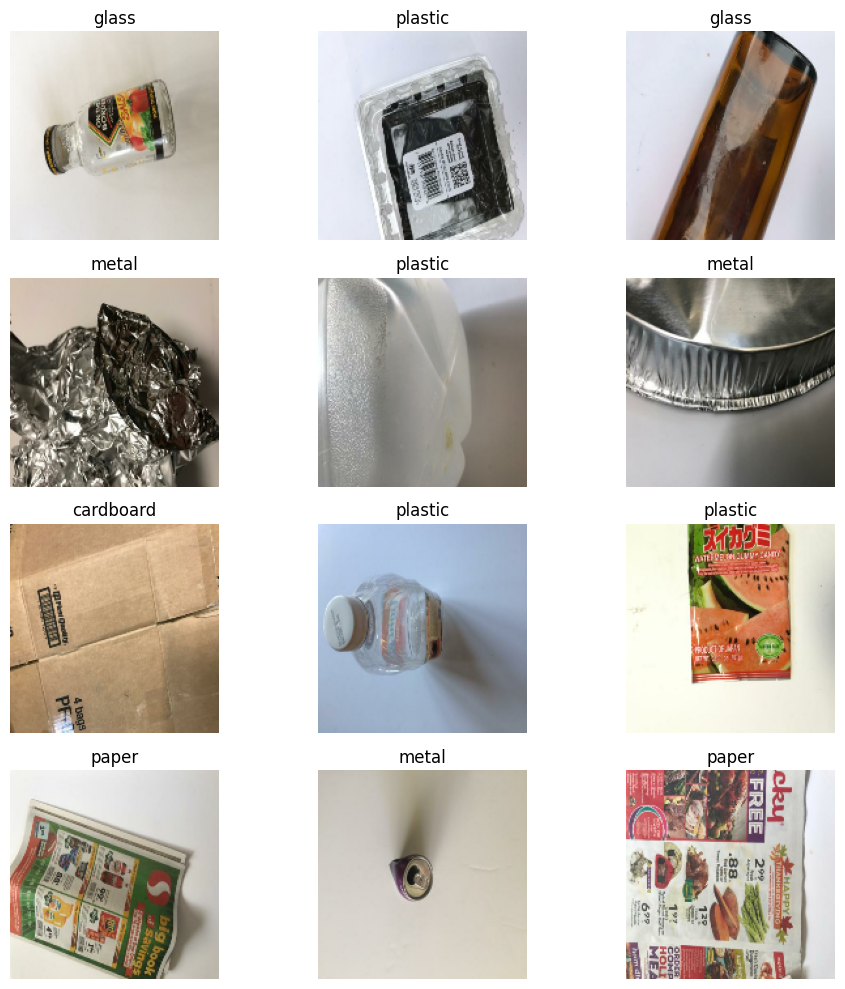

In [11]:
#Sample Images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")
plt.tight_layout()
plt.show()

In [12]:
#Count hte images count in each category
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}
    
    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts

In [13]:
# Function to plot class distribution
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color=['red','blue','green','orange','gray','brown'])
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

In [14]:
class_names = train_ds.class_names

# Get class distributions
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)

#Displaying details
df = pd.DataFrame({
    "Train": train_dist,
    "Validation": val_dist,
    "Test": test_dist,
    "Average (Train+Val)": overall_dist
})
print(df)

           Train  Validation   Test  Average (Train+Val)
cardboard  16.52       13.66  14.06                15.09
glass      19.73       20.20  17.58                19.96
metal      15.92       17.43  16.80                16.68
paper      23.29       24.36  25.00                23.82
plastic    19.44       17.62  19.14                18.53
trash       5.09        6.73   7.42                 5.91


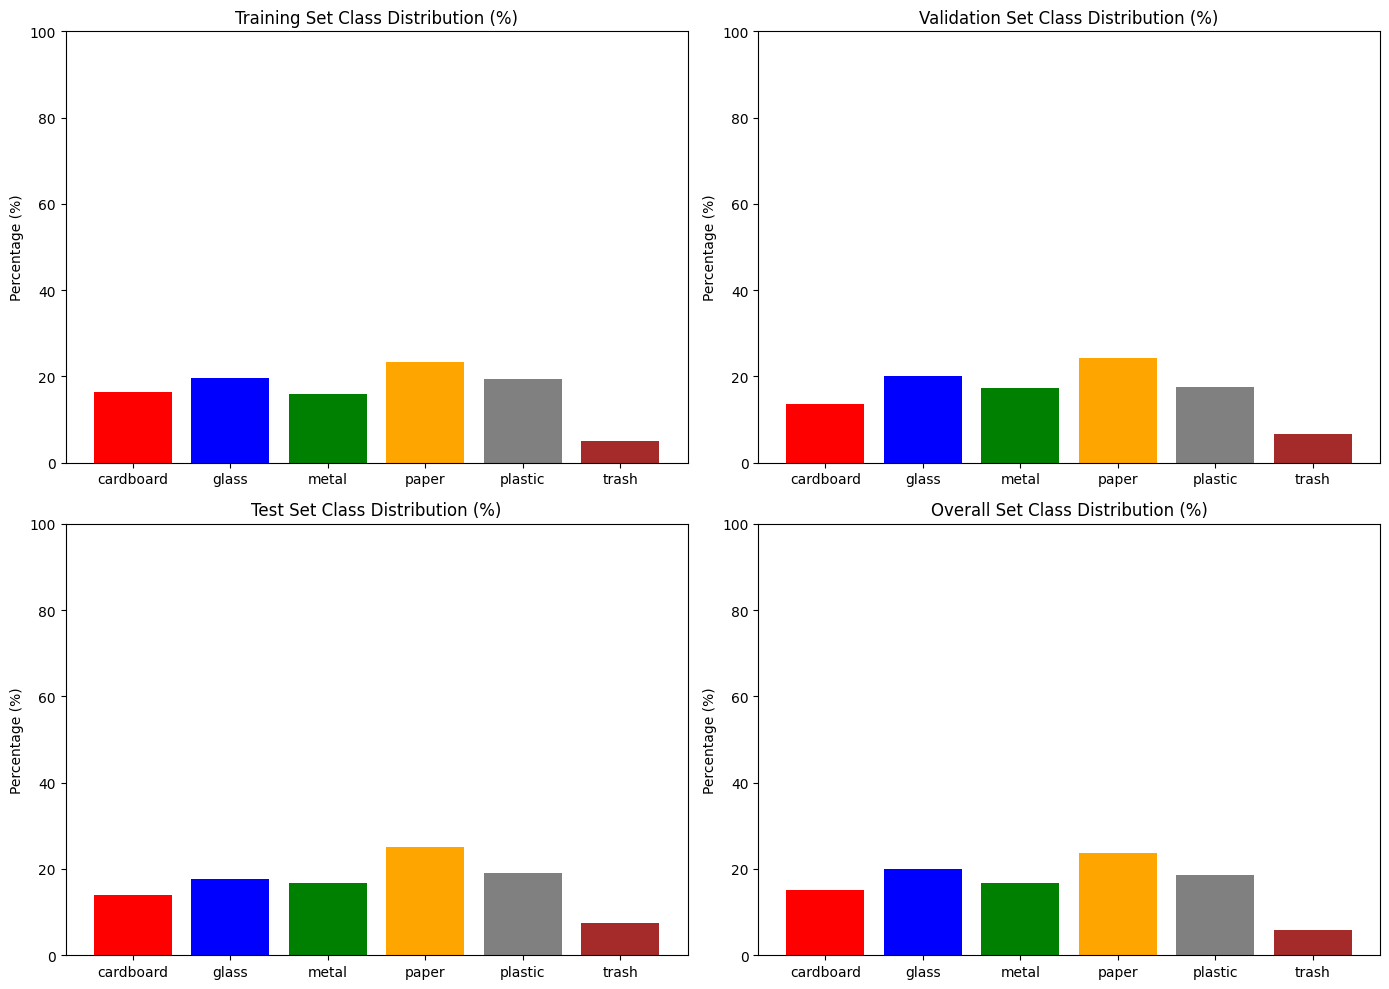

In [15]:
#Visually showing the percentages
def multi_bar_plot(train, val, test, overall, class_names):
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    titles = ["Training", "Validation", "Test", "Overall"]
    datasets = [train, val, test, overall]

    for ax, title, dist in zip(axs.flat, titles, datasets):
        ax.bar(dist.keys(), dist.values(), color=['red','blue','green','orange','gray','brown'])
        ax.set_title(f"{title} Set Class Distribution (%)")
        ax.set_ylabel("Percentage (%)")
        ax.set_ylim(0, 100)
    plt.tight_layout()
    plt.show()

multi_bar_plot(train_dist, val_dist, test_dist, overall_dist, class_names)

In [ ]:
#Computing Class weights
# Count class occurrences and prepare label list for assigining the weights
#weights are used to provide the preference to the minarity classes to remove bias
# lower the frequency higher the weight, higher the frequency lower the weights

class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

# Compute class weights (index aligned)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

# Create dictionary mapping class index to weight
class_weights = {i: w for i, w in enumerate(class_weights_array)}

       Class  Count  Weight
0  cardboard    334  1.0090
1      glass    399  0.8446
2      metal    322  1.0466
3      paper    471  0.7155
4    plastic    393  0.8575
5      trash    103  3.2718


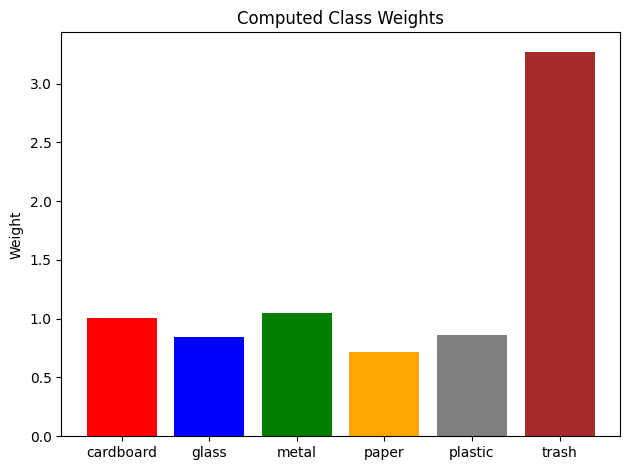

In [17]:
#Displaying the weights
weights_df = pd.DataFrame({
    "Class": [class_names[i] for i in class_weights],
    "Count": [class_counts[i] for i in class_counts],
    "Weight": [round(w, 4) for w in class_weights.values()]
})
print(weights_df)

plt.bar(class_names, class_weights_array, color=['red','blue','green','orange','gray','brown'])
plt.title("Computed Class Weights")
plt.ylabel("Weight")
plt.tight_layout()
plt.show()

2. Data Preprocessing

In [18]:
#Define Data augmentation
#This is applied only during training, not during validation or testing, it helps the model learn invariant features, like recognizing trash even if it's flipped or zoomed in

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),    #Randomly flips the image left-to-right
    layers.RandomRotation(0.25),        #rotate images by 25% i.e ± 90degrees
    layers.RandomZoom(0.1),             #zoom in or out images by 10%
    layers.RandomContrast(0.1),         #Changes the image contrast by ±10%
])

3. Model Selection

In [19]:
base_model = EfficientNetV2B2(
    include_top=False,          #Removing the output layer
    input_shape=(160, 160, 3),  #Sets expected input image size (width, height, RGB channels)
    include_preprocessing=True, #Applies the same preprocessing used during EfficientNetV2 training
    weights='imagenet'          #Pre-trained weights load from ImageNet
)

#  Freeze early layers (to retain general pretrained features)
base_model.trainable = True
for layer in base_model.layers[:100]:  # we can adjust this number
    layer.trainable = False

In [20]:
#  Build the final model
model = Sequential([
    layers.Input(shape=(160, 160, 3)),     #Specifing inputs
    data_augmentation,                     #Applying real-time random transformation
    base_model,                            #Using EfficientNetV2B2 as base without top/output layer
    GlobalAveragePooling2D(),              #Converting final convolutional feature maps into a single vector
    layers.Dropout(0.3),                   #turning off 30% neurons randomly during training to Prevent overfitting
    layers.Dense(6, activation='softmax')  # Change to your number of classes
])

Note:
1. Input	        :   Define image shape
2. Augmentation	:   Improve generalization
3. Pretrained Base	:   Feature extraction (EfficientNet)
4. GAP Layer       :	Flatten CNN output
5. Dropout	        :   Regularization
6. Dense Layer	    :   Classification into 6 categories

In [21]:
#Compiling the model
model.compile(
    #optimizer = 'adam',
    optimizer=optimizers.Adam(learning_rate=1e-4),  #Adam is the best optimizer (learning rate = 0.0001 we can use 0.01 to 0.0001) 
    loss='sparse_categorical_crossentropy',         #Compute loss
    metrics=['accuracy']                            #Compute accuracy
)

In [22]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',           # tracking validation loss to decide when to stop.
    patience=3,                   # Number of epochs to wait after last improvement before stopping (If no improvement happens for 3 epochs → training stops.)
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)

In [23]:
# Set the number of epochs to train the model
epochs = 15  # Number of times the model will go through the entire dataset

# Train the model using the fit function
history = model.fit(
    train_ds,                # Training dataset used to adjust model weights
    validation_data=val_ds,   # Validation dataset to monitor performance on unseen data
    epochs=epochs,           # Number of training cycles, referencing the variable set earlier
    class_weight=class_weights,  # Handles class imbalances by assigning appropriate weights
    batch_size=32,           # Number of samples processed in each training step
    callbacks=[early]        # Implements early stopping to prevent unnecessary training
)

Epoch 1/15


64/64 ━━━━━━━━━━━━━━━━━━━━ 233s 3s/step - accuracy: 0.3089 - loss: 1.6588 - val_accuracy: 0.6970 - val_loss: 1.0487
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.6549 - loss: 1.0227 - val_accuracy: 0.8119 - val_loss: 0.6744
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.8017 - loss: 0.6530 - val_accuracy: 0.8713 - val_loss: 0.4623
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - accuracy: 0.8600 - loss: 0.4558 - val_accuracy: 0.8970 - val_loss: 0.3739
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.8875 - loss: 0.3596 - val_accuracy: 0.9109 - val_loss: 0.3180
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.9137 - loss: 0.2616 - val_accuracy: 0.8970 - val_loss: 0.3044
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 230s 3s/step - accuracy: 0.9380 - loss: 0.2156 - val_accuracy: 0.9129 - val_loss: 0.2693
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.9444 - loss: 0.1729 - val_accuracy: 0.9050 - val_loss: 0.

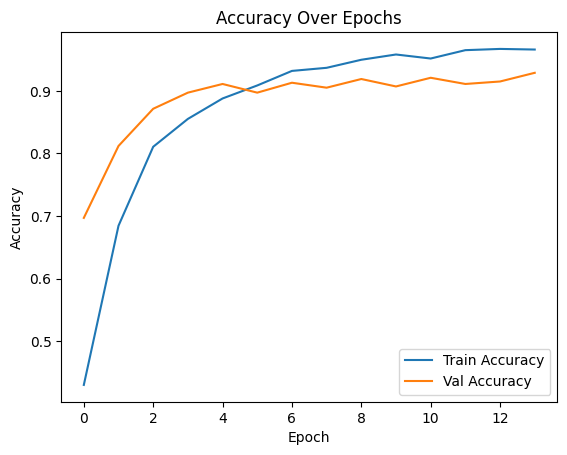

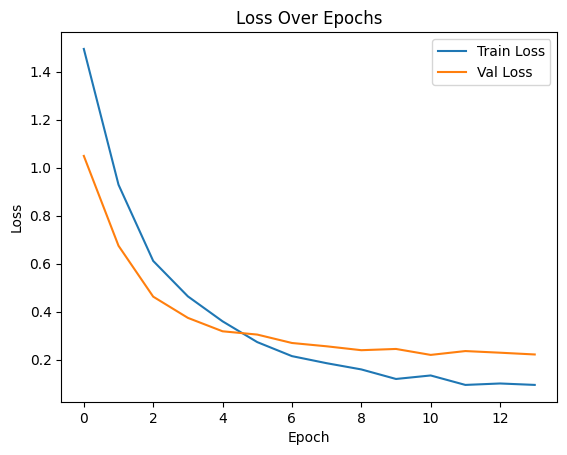

In [24]:
#Visualization
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [25]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 5, 5, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         8,454 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,727,114 (94.33 MB)

 Trainable params: 7,974,642 (30.42 MB)

 Non-trainable params: 803,186 (3.06 MB)

 Optimizer params: 15,949,286 (60.84 MB)

In [26]:
base_model.summary()

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 160, 160,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 160, 160,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 80, 80,    │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 80, 80,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 80, 80,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 80, 80,    │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 80, 80,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 80, 80,    │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 80, 80,    │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 80, 80,    │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 80, 80,    │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 80, 80,    │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 80, 80,    │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 40, 40,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 40, 40,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 40, 40,    │          0 │ block2a_expand_b

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 7,966,188 (30.39 MB)

 Non-trainable params: 803,186 (3.06 MB)

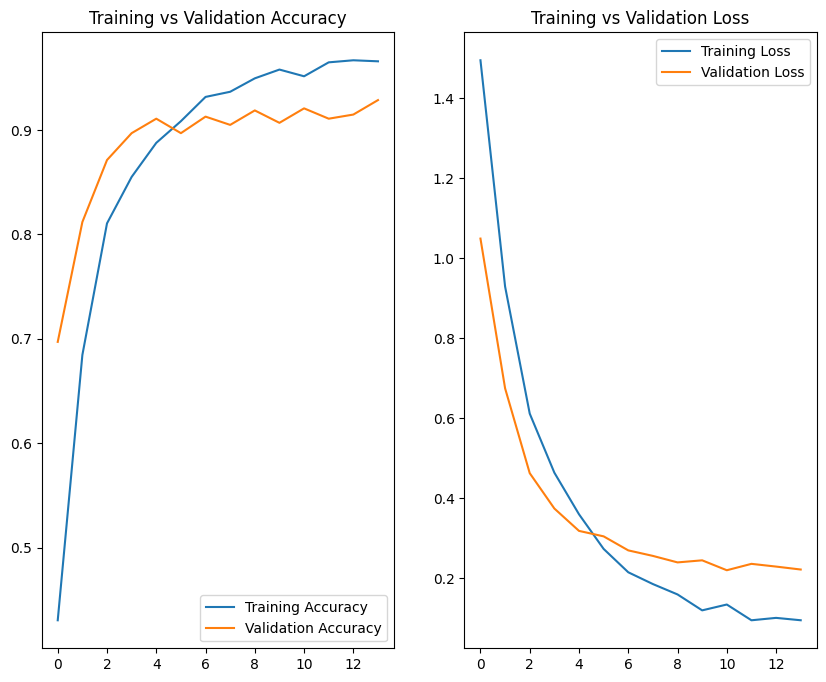

In [27]:
#Ploting the graphs

acc = history.history['accuracy']          # Extract training accuracy from history
val_acc = history.history['val_accuracy']  # Extract validation accuracy from history
loss = history.history['loss']             # Extract training loss from history
val_loss = history.history['val_loss']     # Extract validation loss from history

epochs_range = range(len(acc))             # Define range for epochs based on accuracy length

plt.figure(figsize=(10,8))                 

plt.subplot(1,2,1)                         # Create first subplot (1 row, 2 columns, position 1)
plt.plot(epochs_range, acc, label='Training Accuracy')      
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')   
plt.title('Training vs Validation Accuracy')

plt.subplot(1,2,2)                         # Create second subplot (1 row, 2 columns, position 2)
plt.plot(epochs_range, loss, label='Training Loss')      
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')            
plt.title('Training vs Validation Loss')

plt.show()                                 

5.Model Evaluation

In [28]:
#Evaluation
loss, accuracy = model.evaluate(test_ds_eval)
print(f'Test accuracy is: {accuracy:.4f}, Test loss is: {loss:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 592ms/step - accuracy: 0.9152 - loss: 0.2278
Test accuracy is: 0.9180, Test loss is: 0.2207


In [29]:
# Extract true labels from all batches in the test dataset
y_true = np.concatenate([y.numpy() for x, y in test_ds_eval], axis=0)  # Convert Tensor labels to NumPy array and concatenate them

# Get predictions as probabilities from the model
y_pred_probs = model.predict(test_ds_eval)  # Predict class probabilities for each sample in the test dataset

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # Select the class with the highest probability for each sample

# Compute the confusion matrix to evaluate classification performance
cm = confusion_matrix(y_true, y_pred)  # Generate confusion matrix comparing true labels to predicted labels

# Print metrics to assess model performance
print(cm)  # Display confusion matrix
print(classification_report(y_true, y_pred))  # Print precision, recall, and F1-score for each class


8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 895ms/step
[[28  0  0  2  0  0]
 [ 0 43  4  0  0  0]
 [ 0  0 48  0  1  1]
 [ 2  0  0 58  0  2]
 [ 0  2  2  0 38  3]
 [ 0  0  1  1  0 20]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        30
           1       0.96      0.91      0.93        47
           2       0.87      0.96      0.91        50
           3       0.95      0.94      0.94        62
           4       0.97      0.84      0.90        45
           5       0.77      0.91      0.83        22

    accuracy                           0.92       256
   macro avg       0.91      0.92      0.91       256
weighted avg       0.92      0.92      0.92       256



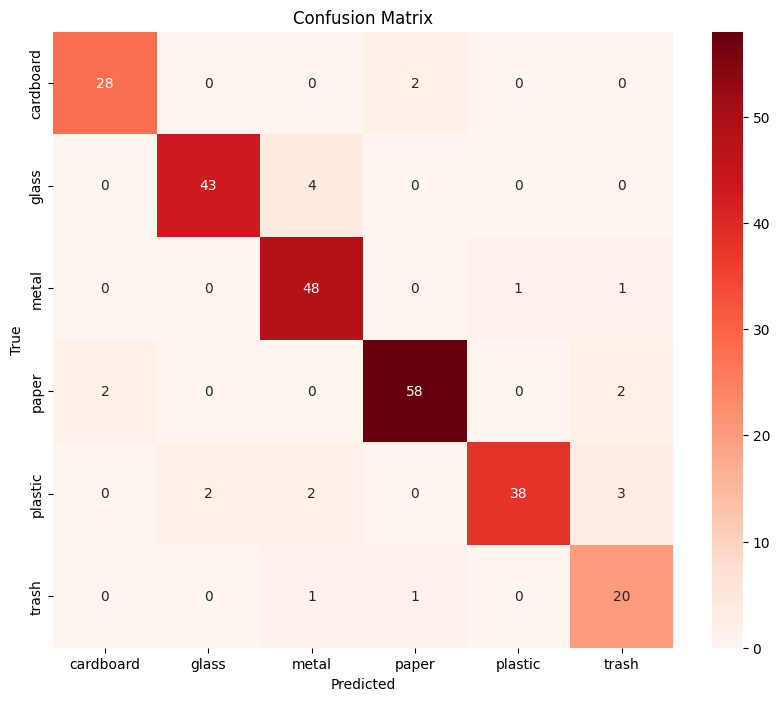

In [30]:
#Confusion Matrix Visuallization
plt.figure(figsize=(10,8))  # Set figure size for better visualization

sns.heatmap(cm, annot=True, fmt='d',  # Create heatmap using confusion matrix
            xticklabels=class_names,  # Set class names for x-axis (predicted labels)
            yticklabels=class_names,  # Set class names for y-axis (true labels)
            cmap='Reds')  # Use a blue colormap for better contrast

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix') 
plt.show()

7.Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


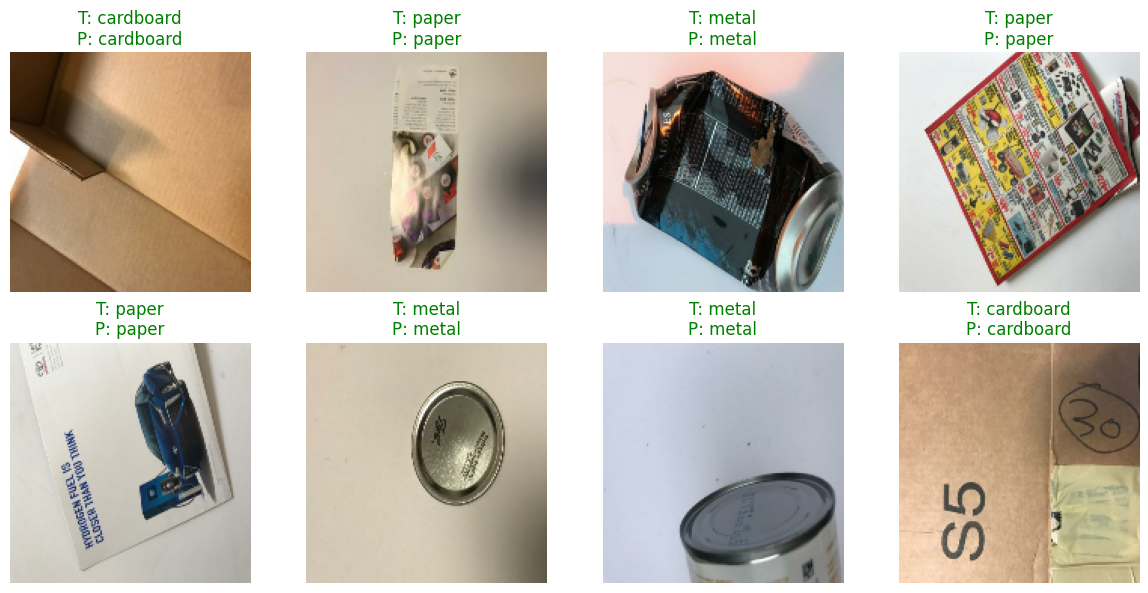

In [31]:
# Extract class names
class_names = train_ds.class_names

# Get one batch from test set
for images, labels in test_ds_eval.take(1):
    predictions = model.predict(images)
    pred_labels = tf.argmax(predictions, axis=1)

    # Plot the first 8 images in a 2x4 grid
    plt.figure(figsize=(12, 6))
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true = class_names[labels[i]]
        pred = class_names[pred_labels[i]]
        color = "green" if true == pred else "red"
        plt.title(f"T: {true}\nP: {pred}", color=color)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


In [32]:
# Save model in Keras format with architecture, weights, and training configuration
model.save('Effiicientnetv2b2.keras')

# Load your Keras model
model = tf.keras.models.load_model('Effiicientnetv2b2.keras')

In [34]:
def classify_image(img):  
    # Resize image to 124x124 pixels (Note: Comment says 128x128, but code resizes to 124x124)
    img = img.resize((160, 160))  
    
    # Convert image to a NumPy array with float32 dtype
    img_array = np.array(img, dtype=np.float32)  
    img_array = preprocess_input(img_array)
    
    # Expand dimensions to match model input shape (adds a batch dimension)
    img_array = np.expand_dims(img_array, axis=0)  
    
    # Make a prediction using the trained model
    prediction = model.predict(img_array)  
    
    # Get the index of the highest predicted probability
    predicted_class_index = np.argmax(prediction)  
    
    # Map the predicted index to its corresponding class name
    predicted_class_name = class_names[predicted_class_index]  
    
    # Extract confidence score (probability of the predicted class)
    confidence = prediction[0][predicted_class_index]  
    
    # Return formatted prediction result with confidence score
    return f"Predicted: {predicted_class_name} (Confidence: {confidence:.2f})"  

In [40]:
iface = gr.Interface(  
    fn=classify_image,            # Function to classify image using the trained model  
    inputs=gr.Image(type="pil"),  # Accepts input as a PIL image  
    outputs="text"                # Outputs prediction as text  
)  

# Launch the interface  
iface.launch()  # Start the Gradio interface for user interaction  

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
